In [2]:
pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 KB 23.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=866f270561c0c4ff08315afda9c2ca1dcf2ee0b840ed983f7225b17fda4660a1
  Stored in directory: /root/.cache/pip/wheels/e6/a6/20/cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built lime


## Import libraries 

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
nlp = spacy.load('en_core_web_sm')
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Dense, Embedding, Dropout
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from lime import lime_text
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

## Load dataset

In [91]:
df = pd.read_csv("/content/drive/MyDrive/IMDB Dataset.csv")


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

In [ ]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [ ]:
df.nunique()

review       49582
sentiment        2
dtype: int64

Text(0.5, 1.0, 'Sentiment Distribution')

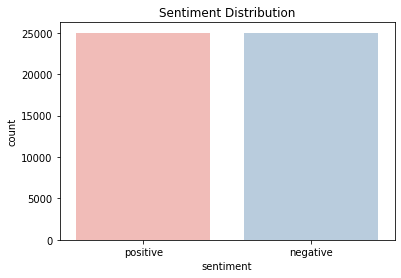

In [ ]:
sns.countplot(x="sentiment", data=df, palette="Pastel1", ).set_title('Sentiment Distribution')

In [ ]:
df.describe().T

count unique                                                top  \
review     50000  49582  Loved today's show!!! It was a variety and not...   
sentiment  50000      2                                           positive   

            freq  
review         5  
sentiment  25000

In [ ]:
df.duplicated().sum()

418

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.duplicated().sum()

0

In [ ]:
# text length
df['text_length'] = df['review'].apply(len)


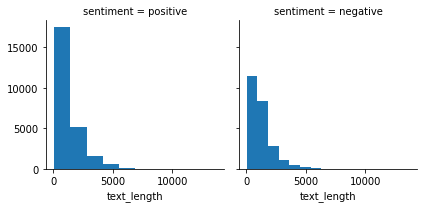

In [ ]:
g = sns.FacetGrid(df,col='sentiment')
g.map(plt.hist,'text_length')

In [6]:
max_len = 5000

In [ ]:
df.head()

review sentiment  text_length
0  One of the other reviewers has mentioned that ...  positive         1761
1  A wonderful little production. <br /><br />The...  positive          998
2  I thought this was a wonderful way to spend ti...  positive          926
3  Basically there's a family where a little boy ...  negative          748
4  Petter Mattei's "Love in the Time of Money" is...  positive         1317

## Preprocess data

In [ ]:
def preprocess_review(spacy_doc: spacy.tokens.doc.Doc) -> str:
    review_clean = [token.lemma_ for token in spacy_doc if token.is_alpha and not token.is_stop]
    return ' '.join(review_clean)


df['spacy_doc'] = df['review'].apply(lambda x: nlp(x))
df['review_clean'] = df['spacy_doc'].apply(lambda x: preprocess_review(x))

In [ ]:
# saving the dataframe
df.to_csv('processed.csv')

In [7]:
df = pd.read_csv('/content/drive/MyDrive/processed.csv')

In [8]:
df = df.drop(columns=['review','text_length', 'spacy_doc','Unnamed: 0'])

In [9]:
df.head()

sentiment                                       review_clean
0  positive  reviewer mention watch oz episode hook right e...
1  positive  wonderful little production br film technique ...
2  positive  think wonderful way spend time hot summer week...
3  negative  basically family little boy Jake think zombie ...
4  positive  Petter Mattei love Time money visually stunnin...

In [10]:
#Encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.sentiment = le.fit_transform(df.sentiment)

In [11]:
df.head()

sentiment                                       review_clean
0          1  reviewer mention watch oz episode hook right e...
1          1  wonderful little production br film technique ...
2          1  think wonderful way spend time hot summer week...
3          0  basically family little boy Jake think zombie ...
4          1  Petter Mattei love Time money visually stunnin...

In [12]:
X = df['review_clean']
y = df['sentiment'].values

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [15]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(39665,) (39665,)
(9917,) (9917,)


In [16]:
# Tokenize the text
max_len = 2000
tokenizer = Tokenizer(num_words=max_len)
tokenizer.fit_on_texts(df['review_clean'].values)

In [22]:
print(tokenizer.word_index)

{'movie': 1, 'film': 2, 'like': 3, 'good': 4, 'time': 5, 'character': 6, 'watch': 7, 'bad': 8, 'story': 9, 'see': 10, 'think': 11, 'scene': 12, 'great': 13, 'look': 14, 'know': 15, 'people': 16, 'go': 17, 'love': 18, 'play': 19, 'way': 20, 'come': 21, 'thing': 22, 'find': 23, 'br': 24, 'man': 25, 'end': 26, 'life': 27, 'get': 28, 'plot': 29, 'work': 30, 'actor': 31, 'want': 32, 'year': 33, 'make': 34, 'try': 35, 'little': 36, 'well': 37, 'feel': 38, 'give': 39, 'take': 40, 'old': 41, 'director': 42, 'lot': 43, 'real': 44, 'guy': 45, 'acting': 46, 'show': 47, 'performance': 48, 'funny': 49, 'woman': 50, 'big': 51, 'actually': 52, 'say': 53, 'new': 54, 'role': 55, 'leave': 56, 'star': 57, 'young': 58, 'act': 59, 'tell': 60, 'start': 61, 'long': 62, 'point': 63, 'cast': 64, 'girl': 65, 'day': 66, 'turn': 67, 'world': 68, 'horror': 69, 'fact': 70, 'comedy': 71, 'pretty': 72, 'minute': 73, 'action': 74, 'happen': 75, 'kill': 76, 'set': 77, 'line': 78, 'right': 79, 'need': 80, 'bit': 81, 'fa

In [18]:
X = tokenizer.texts_to_sequences(df['review_clean'].values)
X = pad_sequences(X, maxlen=max_len)

In [23]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:

y_train = y_train.reshape((39665, -1))
y_test = y_test.reshape((9917, -1))

In [26]:
y_train

array([[0],
       [0],
       [1],
       ...,
       [0],
       [1],
       [1]])

In [27]:
X_train.shape

(39665, 2000)

In [24]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(39665, 2000) (39665,)
(9917, 2000) (9917,)


# Build model - LSTM Network

In [28]:
# Define the model
model = Sequential()
model.add(Embedding(2000, 128))
model.add(LSTM(128,dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = Adam(learning_rate = 0.0001),loss = 'binary_crossentropy', metrics = ['accuracy'])

Model information
- summary information of model
- plot model

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         256000    
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 387,713
Trainable params: 387,713
Non-trainable params: 0
_________________________________________________________________


Training model
- optimizer: Adam
- loss: binary crossentropy
- epochs: 10
- chcekpoint: minimum val_loss
- batch size: 64

In [30]:
saved_model = 'lstm.hdf5'
checkpoint = ModelCheckpoint(saved_model, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

epochs = 10
batch_size = 64
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=epochs, batch_size=batch_size,callbacks = [checkpoint])

Epoch 1/10
620/620 [==============================] - ETA: 0s - loss: 0.4907 - accuracy: 0.7746
Epoch 1: val_accuracy improved from -inf to 0.85328, saving model to lstm.hdf5
620/620 [==============================] - 64s 95ms/step - loss: 0.4907 - accuracy: 0.7746 - val_loss: 0.3434 - val_accuracy: 0.8533
Epoch 2/10
620/620 [==============================] - ETA: 0s - loss: 0.3180 - accuracy: 0.8685
Epoch 2: val_accuracy improved from 0.85328 to 0.86397, saving model to lstm.hdf5
620/620 [==============================] - 67s 108ms/step - loss: 0.3180 - accuracy: 0.8685 - val_loss: 0.3272 - val_accuracy: 0.8640
Epoch 3/10
620/620 [==============================] - ETA: 0s - loss: 0.2955 - accuracy: 0.8783
Epoch 3: val_accuracy improved from 0.86397 to 0.86619, saving model to lstm.hdf5
620/620 [==============================] - 61s 98ms/step - loss: 0.2955 - accuracy: 0.8783 - val_loss: 0.3151 - val_accuracy: 0.8662
Epoch 4/10
620/620 [==============================] - ETA: 0s - loss:

PLOT: training process
- we use ModelCheckpoint -> saved model with the max validation accuracy 

In [31]:
def trainingProcess(history):
    plt.style.use('ggplot')
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    plt.style.use('ggplot')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

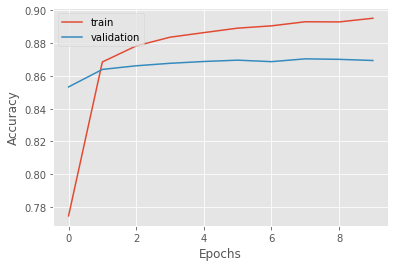

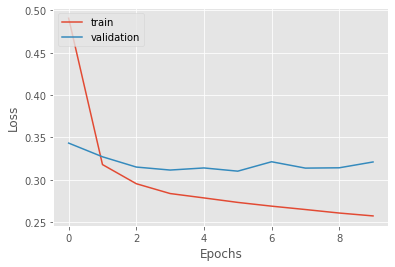

In [32]:
trainingProcess(history)

Model Prediction and Evaluation

In [33]:
# load best model
myModel = load_model('lstm.hdf5') 

In [34]:
# Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

310/310 [==============================] - 8s 24ms/step
              precision    recall  f1-score   support

           0       0.88      0.85      0.87      4939
           1       0.86      0.88      0.87      4978

    accuracy                           0.87      9917
   macro avg       0.87      0.87      0.87      9917
weighted avg       0.87      0.87      0.87      9917



In [93]:
# evaluate performance of trained model on test data
evaluation = myModel.evaluate(X_test, y_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

310/310 [==============================] - 9s 27ms/step - loss: 0.3139 - accuracy: 0.8704
Test Accuracy : 87.04%


In [94]:
# make prediction of trained model on test data
pred = myModel.predict(X_test)
y_pred = np.argmax(pred,axis =0)
y_test=np.argmax(y_test, axis=0)

310/310 [==============================] - 23s 25ms/step


In [95]:
pred2=myModel.predict(X_test)
print(X_test.shape)
print(pred2.shape)

PRED=[]
for item in pred2:
    value2=np.argmax(item)      
    PRED+=[value2]

310/310 [==============================] - 8s 25ms/step
(9917, 2000)
(9917, 1)


Print Classification Report

In [35]:
confusion_matrix(y_test, y_pred)

array([[4217,  722],
       [ 573, 4405]])

# Explainability methods

#1. LIME

In [86]:
from lime.lime_text import LimeTextExplainer
import tensorflow as tf

explainer = LimeTextExplainer(class_names=["positive", "negative"])

def predict_function(x):

    test_seq = tokenizer.texts_to_sequences(x)
    test_pad = tf.keras.preprocessing.sequence.pad_sequences(test_seq, maxlen=max_len)
    pred = model.predict(test_pad)

    format_pred = np.concatenate([1.0-pred, pred], axis=1)

    return format_pred

exp = explainer.explain_instance(df.review_clean[22], predict_function, num_features=7)

print(exp.as_list())

157/157 [==============================] - 4s 25ms/step
[('stunning', 0.11713938218246017), ('fun', 0.09524967887809965), ('like', 0.07346246831729014), ('regret', 0.05120596663236753), ('grow', 0.04159833368252122), ('start', -0.040455508507455246), ('absolutely', -0.02837237818323189)]


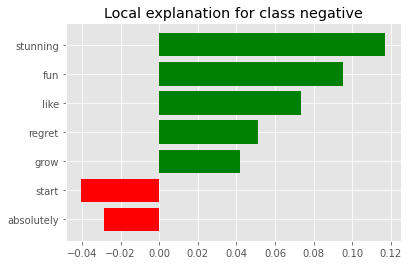

In [87]:
%matplotlib inline
fig = exp.as_pyplot_figure()

In [88]:
exp.show_in_notebook(text=True)

In [89]:
df.review_clean[22]

'absolutely stunning movie hrs kill watch will regret fun Rajnikanth carry movie shoulder like music take time grow hear time start like'

In [92]:
df.review[22]

"What an absolutely stunning movie, if you have 2.5 hrs to kill, watch it, you won't regret it, it's too much fun! Rajnikanth carries the movie on his shoulders and although there isn't anything more other than him, I still liked it. The music by A.R.Rehman takes time to grow on you but after you heard it a few times, you really start liking it."

# 1. SHAP

In [47]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 36.7 MB/s eta 0:00:00


In [60]:
import shap
shap.initjs()

In [61]:
# Create an explainer object
explainer = shap.explainers.Permutation(model.predict, X_train, max_evals = 2000)

In [62]:
# Explain the first test instance
shap_values = explainer(X_test[:10])


489/489 [==============================] - 12s 25ms/step


Permutation explainer:  10%|█         | 1/10 [00:00<?, ?it/s]

602/602 [==============================] - 15s 24ms/step


Permutation explainer:  30%|███       | 3/10 [02:14<04:36, 39.43s/it]

783/783 [==============================] - 19s 24ms/step


Permutation explainer:  40%|████      | 4/10 [04:27<07:49, 78.29s/it]

847/847 [==============================] - 20s 24ms/step


Permutation explainer:  50%|█████     | 5/10 [06:29<07:53, 94.79s/it]

857/857 [==============================] - 21s 24ms/step


Permutation explainer:  60%|██████    | 6/10 [08:47<07:18, 109.50s/it]

481/481 [==============================] - 11s 24ms/step


Permutation explainer:  70%|███████   | 7/10 [09:50<04:42, 94.16s/it] 

390/390 [==============================] - 10s 24ms/step


Permutation explainer:  80%|████████  | 8/10 [11:02<02:54, 87.21s/it]

389/389 [==============================] - 9s 24ms/step


Permutation explainer:  90%|█████████ | 9/10 [11:57<01:16, 76.87s/it]

458/458 [==============================] - 11s 24ms/step


Permutation explainer: 100%|██████████| 10/10 [13:04<00:00, 73.75s/it]

451/451 [==============================] - 11s 24ms/step


Permutation explainer: 11it [14:11, 85.10s/it]


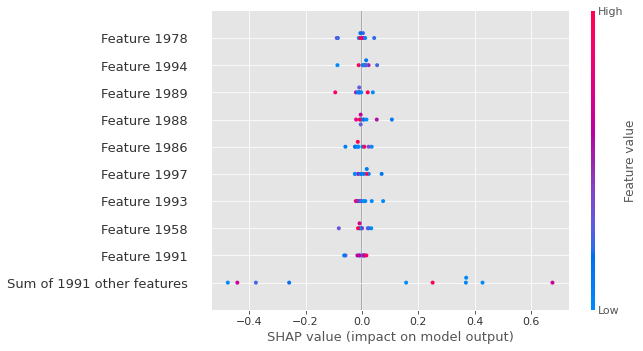

In [63]:
shap.plots.beeswarm(shap_values)

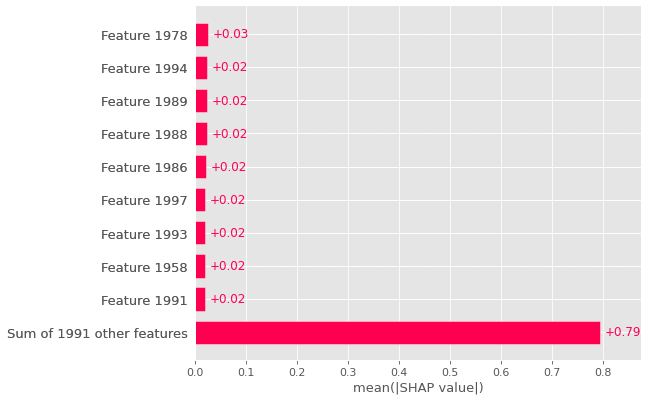

In [64]:
shap.plots.bar(shap_values)

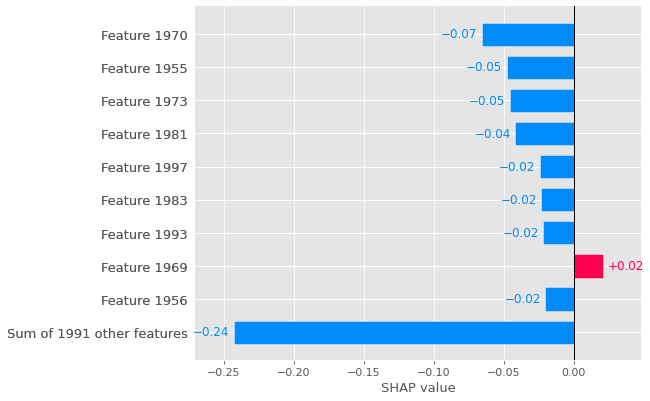

In [65]:
shap.plots.bar(shap_values[0])

In [73]:
# X_shap = shap.utils.sample(X1000, 1000,random_state=42)
X_shap = X_train[:1000]